In [17]:
import pandas as pd
import math

# Read the CSV file
df = pd.read_csv('d3_with_clash_info.csv')
df = df[df['group'] == 'valid']

# Remove the leading '/' from af2File column and rename it to protein_path
df['protein_path'] = df['af2File'].str.lstrip('/')
df.drop('af2File', axis=1, inplace=True)

# Remove the leading '/' from ligandFile column and rename it to ligand
df['ligand'] = df['ligandFile'].str.lstrip('/')
df.drop('ligandFile', axis=1, inplace=True)

# Calculate the number of chunks
num_chunks = math.ceil(len(df) / 100)

# Save each chunk of 200 rows with a different filename
for i in range(num_chunks):
    start_index = i * 100
    end_index = min((i + 1) * 100, len(df))
    chunk_df = df.iloc[start_index:end_index]
    chunk_df[['protein_path', 'ligand']].to_csv(f'valid_pdb_{i}.csv', index=False)


# Save the modified dataframe to aft_input.csv
# df[['protein_path', 'ligand']].to_csv('valid_pdb.csv', index=False)


In [ ]:
from analysis import *
df2 = pd.read_csv('result_bkup/complete_affinity_prediction.csv')
df2 = df2[df['group'] == 'test']
# Remove the leading '/' from af2File column and rename it to protein_path
df2['protein_path'] = df2['af2File'].str.lstrip('/')
df2.drop('af2File', axis=1, inplace=True)

# Remove the leading '/' from ligandFile column and rename it to ligand
df2['ligand'] = df2['ligandFile'].str.lstrip('/')
df2.drop('ligandFile', axis=1, inplace=True)

In [ ]:
from analysis import *
def compute_clash_and_rmsd_impl(x):
    if len(x) == 6:
        cur_pre, header, pdbFile, af2File, ligandFile, infoFile = x
        gap_mask = None
    else:
        cur_pre, header, pdbFile, af2File, ligandFile, infoFile, gap_mask = x
    # if os.path.exists(infoFile):
    #     return None
    # print(x)
    info = []
    clash_query_list = []
    rank_list = range(1, 41)
    for rank in rank_list:
        pred_proteinFile = f"{cur_pre}/{header}_rank{rank}_receptor.pdb"
        # if header in ['diffdock_af2_all', 'diffdock_random1', 'diffdock_small_af2_all']:
        if 'crystal' in header and 'diffdock' in header:
            pred_proteinFile = pdbFile
        elif "diffdock" in header:
            pred_proteinFile = af2File
        pred_ligandFile = f"{cur_pre}/{header}_rank{rank}_ligand.sdf"
        clash_query_list.append((f'{header}', rank, pred_proteinFile, pred_ligandFile))

    ref_mol = Chem.MolFromMolFile(ligandFile)
    ref_ligand_coords = ref_mol.GetConformer().GetPositions()

    for (conformation, rank, p, l) in clash_query_list:
        try:
            rmsd = compute_RMSD(Chem.MolFromMolFile(l).GetConformer().GetPositions(),
                            ref_ligand_coords)
            rmsd_sym = get_symmetry_rmsd(ref_mol, ref_ligand_coords, Chem.MolFromMolFile(l).GetConformer().GetPositions())
        except Exception as e:
            # print(e, l)
            if str(e) == "Timed out!":
                rmsd_sym = rmsd
            else:
                # skip_pdb_list.append(entryName)
                print(e, "compute RMSD")
                continue
        # info.append([conformation, rank, -1, -1, -1, -1, -1, -1, 0, 0, 0, rmsd_sym, rmsd])
        # continue
        try:
            clashScore, overlap, clash_n, n = compute_side_chain_metrics(p, l, verbose=True)
            overlap_mean = overlap.mean() if len(overlap) > 0 else 0
        except Exception as e:
            print("compute side chain metrics error", p, l)
            clashScore = -1.0
            overlap_mean = 0
            clash_n = n = 0
        # protein_rmsd = compute_protein_RMSD(pdbFile, p)
        try:
            with time_limit(60):
                protein_rmsd, pocket_rmsd = compute_protein_RMSD(pdbFile, p, ref_ligand_coords=ref_ligand_coords, gap_mask=gap_mask)
            with time_limit(60):
                result = compute_lddt(p, pdbFile, need_alignment=False, per_res=None, binding_site=ref_ligand_coords, gap_mask=gap_mask)
            lddt = result['lddt']
            bs_lddt = result['bs_lddt']
        except Exception as e:
            print("compute_protein_RMSD or lddt error", e, p, l)
            protein_rmsd = pocket_rmsd = -1
            lddt = bs_lddt = -1
        try:
            tmscore = compute_tmscore(p, pdbFile)['tmscore']
        except Exception as e:
            print(e)
            if str(e) == "Timed out!":
                tmscore = -1
            else:
                # skip_pdb_list.append(entryName)
                print(e, "compute tmscore")
                continue
        info.append([conformation, rank, protein_rmsd, pocket_rmsd, clashScore, lddt, bs_lddt, tmscore, overlap_mean, clash_n, n, rmsd_sym, rmsd])

    info = pd.DataFrame(info, columns=['conformation', 'rank', 'protein_rmsd', 'pocket_rmsd',
                                       'clashScore', 'lddt', 'bs_lddt', 'tmscore', 'overlap_mean', 'clash_n', 'n', 'rmsd', 'rmsd_unsym'])
    info.to_csv(infoFile)

In [ ]:
import analysis
import pandas as pd
df = pd.read_csv('eval_metrics.csv')
for index, row in df.iterrows():
    ori_lig = row['referligand']
    infer_rk1 = row['resultligand']
    rmsd = analysis.compute_RMSD(Chem.MolFromMolFile(ori_lig).GetConformer().GetPositions(),
                                Chem.MolFromMolFile(infer_rk1).GetConformer().GetPositions())
    rmsd_sym = analysis.get_symmetry_rmsd(Chem.MolFromMolFile(ori_lig), Chem.MolFromMolFile(ori_lig).GetConformer().GetPositions()
                                          , Chem.MolFromMolFile(infer_rk1).GetConformer().GetPositions())
    print(rmsd, rmsd_sym)

In [12]:
from rdkit import Chem
from rdkit.Chem import rdMolAlign

def compute_rmsd(mol1, mol2):
    # 将分子对齐
    rdMolAlign.AlignMol(mol1, mol2)

    # 计算均方根误差
    rmsd = rdMolAlign.GetBestRMS(mol1, mol2)

    return rmsd
ori_lig = 'results/test/index0_idx_0/5h22.sdf'
infer_rk1 = 'results/test/index0_idx_0/rank1_ligand_lddt0.66_affinity7.63.sdf'

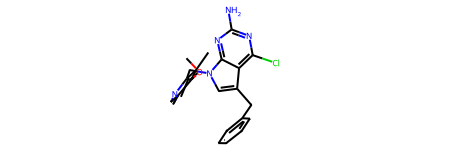

In [13]:
Chem.MolFromMolFile(infer_rk1)

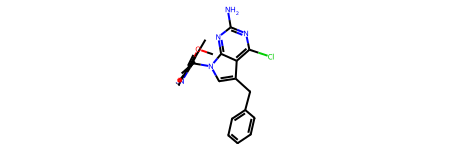

In [14]:
Chem.MolFromMolFile(ori_lig)

In [16]:
import analysis
print(analysis.compute_RMSD(Chem.MolFromMolFile(infer_rk1).GetConformer().GetPositions(),
                      Chem.MolFromMolFile(ori_lig).GetConformer().GetPositions()))

mol1 = Chem.MolFromMolFile(ori_lig)
mol2 = Chem.MolFromMolFile(infer_rk1)

rmsd = compute_rmsd(mol1, mol2)
print(f"均方根误差：{rmsd}")


1.7234362411303121
均方根误差：1.1202891990772899
